In [1]:
import os
import json
import time
import math
import matplotlib.pyplot as plt
from core.data_processor import DataLoader
from core.model import Model

Using TensorFlow backend.


[Model] Model Compiled
Time taken: 0:00:00.814026
[Model] Training Started
[Model] 1 epochs, 32 batch size, 248 batches per epoch
Epoch 1/1
248/248 [==============================] - 41s 163ms/step - loss: 9.9810e-04
[Model] Training Completed. Model saved as saved_models/09092018-162652-e1.h5
Time taken: 0:00:43.593297


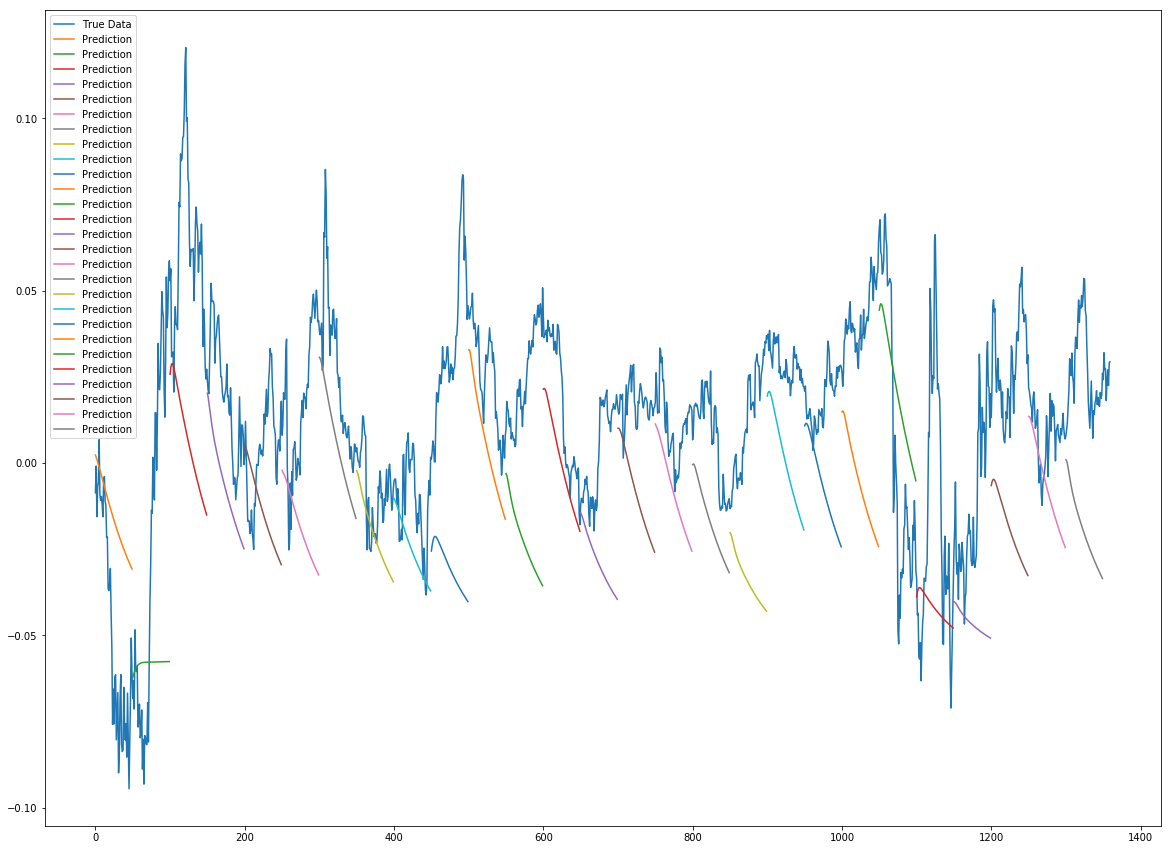

In [2]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white', figsize=(40,30))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(20,15))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def main():
    configs = json.load(open('config.json', 'r'))

    data = DataLoader(
        os.path.join('data', configs['data']['filename']),
        configs['data']['train_test_split'],
        configs['data']['columns']
    )

    model = Model()
    model.build_model(configs)
    x, y = data.get_train_data(
        seq_len = configs['data']['sequence_length'],
        normalise = configs['data']['normalise']
    )

    '''
    # in-memory training
    model.train(
        x,
        y,
        epochs = configs['training']['epochs'],
        batch_size = configs['training']['batch_size']
    )
    '''

    # out-of memory generative training
    steps_per_epoch = math.ceil((data.len_train - configs['data']['sequence_length']) / configs['training']['batch_size'])
    model.train_generator(
        data_gen = data.generate_train_batch(
            seq_len = configs['data']['sequence_length'],
            batch_size = configs['training']['batch_size'],
            normalise = configs['data']['normalise']
        ),
        epochs = configs['training']['epochs'],
        batch_size = configs['training']['batch_size'],
        steps_per_epoch = steps_per_epoch
    )

    x_test, y_test = data.get_test_data(
        seq_len = configs['data']['sequence_length'],
        normalise = configs['data']['normalise']
    )

    predictions = model.predict_sequences_multiple(x_test, configs['data']['sequence_length'], configs['data']['sequence_length'])
    #predictions = model.predict_sequence_full(x_test, configs['data']['sequence_length'])
    #predictions = model.predict_point_by_point(x_test)        

    plot_results_multiple(predictions, y_test, configs['data']['sequence_length'])
    #plot_results(predictions, y_test)

if __name__=='__main__':
    main()